In [ ]:
# !pip install datasets

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd

c:\Users\Wiktoria\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Dataset
https://huggingface.co/datasets/huggan/wikiart

In [3]:
def plot_histogram(data, title):

    plt.figure(figsize=(8, 6))
    plt.hist(data, bins=range(min(data), max(data) + 2), edgecolor='black')
    plt.title(title)
    plt.xlabel("Values")
    plt.ylabel("Frequency")
    plt.show()

In [5]:
dataset = load_dataset("huggan/wikiart", split="train")

In [6]:
print(f"Total number of records: {len(dataset)}")
print(f"Number of columns: {len(dataset.column_names)}")
print(dataset.column_names)

Total number of records: 81444
Number of columns: 4
['image', 'artist', 'genre', 'style']


In [7]:
unique_genres = set(dataset['genre'])
print(f"Number of genres: {unique_genres.__len__()}")
print(f"Unique genres: {unique_genres}")

Number of genres: 11
Unique genres: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}


In [8]:
unique_style = set(dataset['style'])
print(f"Number of styles: {unique_style.__len__()}")
print(f"Unique styles: {unique_style}")

Number of styles: 27
Unique styles: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


We will be using only 2 columns: image and genre

In [9]:
df = pd.DataFrame(dataset['genre'], columns=['genre'])

genre_counts = df['genre'].value_counts()
sorted_counts = genre_counts.sort_index(ascending=True)

sorted_counts_df = pd.DataFrame(sorted_counts).reset_index()
sorted_counts_df.columns = ['genre', 'count']
sorted_counts_df.style.hide_index()


genre,count
0,4968
1,4602
2,10859
3,1902
4,13358
5,1923
6,14112
7,6538
8,3942
9,2788


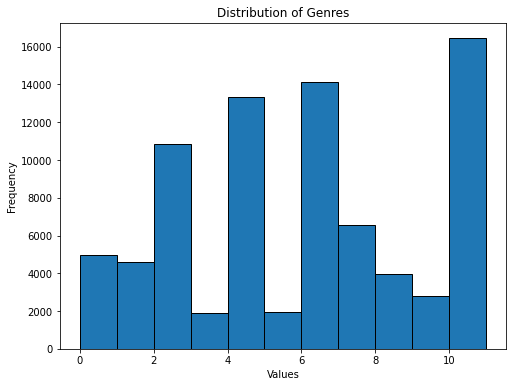

In [10]:
plot_histogram(dataset['genre'], "Distribution of Genres")

Concerning disproportion  in distribution of genres. This may negatively impact the classification results. 

In [20]:
list_of_images = []
for genre in unique_genres:
    for i in range(len(dataset)):
        if dataset[i]['genre'] == genre:
            list_of_images.append(dataset[i]['image'])
            break

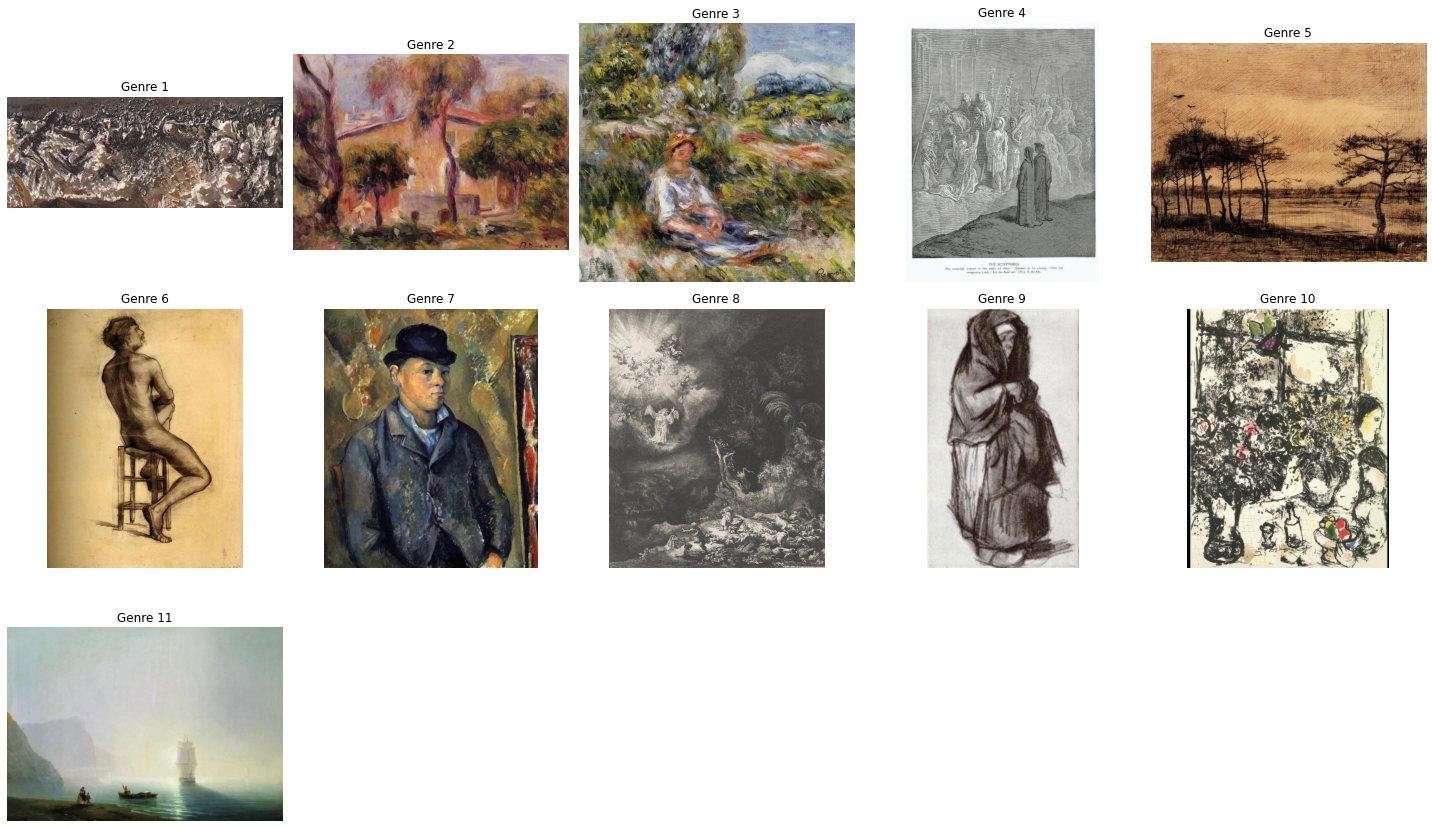

In [44]:
plt.figure(figsize=(20, 20))
for i in range(len(list_of_images)):
    plt.subplot(5, 5, i + 1)
    plt.imshow(list_of_images[i])
    plt.title(f"Genre {i + 1}")
    plt.axis('off')
plt.tight_layout()
plt.show()


## ViT